<a href="https://colab.research.google.com/github/thehydrowave/Adversarial-diffusion-distillation-pokemon/blob/main/Student_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modèle Student

## 1. Installation des dépendances

In [1]:
!pip install numpy==1.26.4 diffusers==0.25.1 transformers==4.37.2 accelerate==0.27.2 \
datasets==2.17.0 huggingface_hub==0.25.0 peft==0.7.1 fsspec==2023.6.0 \
torch==2.2.2 torchvision==0.17.2 pandas==2.2.2 timm --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 134.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 131.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 120.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 156.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 138.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 334.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 383.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6

## 2. Importation des modules

In [2]:
# Core Libraries
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image

# PyTorch & Vision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Hugging Face Diffusers & Transformers
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.models.attention_processor import LoRAAttnProcessor

# Datasets
from datasets import load_dataset, Dataset

# Affichage
import matplotlib.pyplot as plt

# Autres
import timm

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## 3. Initialisation du modèle Teacher

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
teacher = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## 4. Application de LoRA (Low-Rank Adaptation)

In [4]:
def inject_lora_modules(unet):
    # Récupérer la config des dimensions des layers
    cross_attention_dim = unet.config.cross_attention_dim
    attention_dims = {
        "mid_block": unet.config.block_out_channels[-1],
        "up_blocks.3": unet.config.block_out_channels[0],
        "up_blocks.2": unet.config.block_out_channels[1],
        "up_blocks.1": unet.config.block_out_channels[2],
        "up_blocks.0": unet.config.block_out_channels[3],
        "down_blocks.0": unet.config.block_out_channels[0],
        "down_blocks.1": unet.config.block_out_channels[1],
        "down_blocks.2": unet.config.block_out_channels[2],
        "down_blocks.3": unet.config.block_out_channels[3],
    }

    # Injecter les LoRA à la main
    attn_processors = {}
    for name, processor in unet.attn_processors.items():
        for block_key in attention_dims:
            if name.startswith(block_key):
                hidden_size = attention_dims[block_key]
                is_cross_attention = name.endswith("attn2.processor")

                attn_processors[name] = LoRAAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim if is_cross_attention else None
                )
                break
        else:
            # Ne pas modifier les autres
            attn_processors[name] = processor

    unet.set_attn_processor(attn_processors)
    print(f"LoRA injecté dans {sum(isinstance(p, LoRAAttnProcessor) for p in attn_processors.values())} couches.")

## 5. Chargement des poids LoRA

In [5]:
def load_lora_weights_from_bin(unet, lora_path):
    print(f"Chargement des poids LoRA depuis : {lora_path}")
    lora_weights = torch.load(lora_path)
    updated = 0
    for full_key, module in unet.attn_processors.items():
        if hasattr(module, 'load_state_dict'):
            prefix = full_key + "."
            sub_state_dict = {k[len(prefix):]: v for k, v in lora_weights.items() if k.startswith(prefix)}
            if sub_state_dict:
                try:
                    module.load_state_dict(sub_state_dict, strict=False)
                    updated += 1
                except Exception as e:
                    print(f"Erreur pour {full_key} : {e}")
    print(f"{updated}/{len(unet.attn_processors)} modules LoRA mis à jour.")

## 6. Initialisation du modèle Student

In [6]:
inject_lora_modules(teacher.unet)
load_lora_weights_from_bin(teacher.unet, "./teacher_lora_weights.bin")

student = copy.deepcopy(teacher)
student.scheduler.set_timesteps(num_inference_steps=4)

LoRA injecté dans 0 couches.
Chargement des poids LoRA depuis : ./teacher_lora_weights.bin
32/32 modules LoRA mis à jour.


## 7. Discriminateur

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('resnet18', pretrained=True, num_classes=1)

    def forward(self, x):
        return self.backbone(x)

discriminator = Discriminator().to(device)

## 8. Chargement du Dataset Naruto

In [8]:
# Chargement du dataset personnalisé
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

# Transformation : redimension
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Traitement du dataset
def transform_example(example):
    image = example["image"].convert("RGB")
    example["pixel_values"] = transform(image)
    return example

dataset = dataset.map(transform_example)

def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    prompts = [x["text"] for x in batch]
    return pixel_values, prompts

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Repo card metadata block was not found. Setting CardData to empty.


Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

## 9. Boucle d'entraînement


In [9]:
# 1. Initialisation du scheduler avant la boucle d'entraînement
scheduler = DDIMScheduler.from_config(student.scheduler.config)
scheduler.set_timesteps(num_inference_steps=4)

# 2. Initialisation une seule fois de l'optimizer_student avant la boucle
lora_params = []
for name, module in student.unet.attn_processors.items():
    if isinstance(module, LoRAAttnProcessor):
        module.to(device)
        for param in module.parameters():
            param.requires_grad = True
            lora_params.append(param)
optimizer_student = torch.optim.Adam(lora_params, lr=1e-5)

# 3. Entraînement
lambda_adv = 0.5
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-5)
adversarial_loss_fn = nn.BCEWithLogitsLoss()
mse_loss_fn = nn.MSELoss()

for epoch in range(10):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for idx, (pixel_values, prompts) in enumerate(loop):
        pixel_values = pixel_values.to(device, dtype=torch.float16)
        batch_size = pixel_values.shape[0]

        # Encoder les prompts
        inputs = teacher.tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt").to(device)
        encoder_hidden_states = teacher.text_encoder(**inputs).last_hidden_state

        # Générer timestep t cohérent avec scheduler
        t = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

        # Encode les images en latents (teacher)
        latents = teacher.vae.encode(pixel_values).latent_dist.sample() * 0.18215
        noise = torch.randn_like(latents)
        x_t = scheduler.add_noise(latents, noise, t)
        target = noise

        # === Génération des images FAKE par le Student ===
        with torch.no_grad():
            student.unet.eval()
            noise_pred = student.unet(x_t, t, encoder_hidden_states).sample

            # Assurer cohérence des devices pour scheduler.step()
            noise_pred_cpu = noise_pred.cpu()
            t_cpu = t.cpu()
            x_t_cpu = x_t.cpu()

            latents_fake = scheduler.step(noise_pred_cpu, t_cpu, x_t_cpu).prev_sample.to(device)

            # Décodage
            gen_images = student.vae.decode(latents_fake.half()).sample
            gen_images = (gen_images / 2 + 0.5).clamp(0, 1)

        # === Entraînement du Discriminateur ===
        discriminator.train()
        discriminator.zero_grad()

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_output = discriminator(pixel_values.float())
        fake_output = discriminator(gen_images.detach().float())

        d_loss_real = adversarial_loss_fn(real_output, real_labels)
        d_loss_fake = adversarial_loss_fn(fake_output, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_disc.step()

        # === Entraînement du Student ===
        student.unet.train()
        optimizer_student.zero_grad()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            noise_pred = student.unet(x_t, t, encoder_hidden_states).sample
            loss_sds = mse_loss_fn(noise_pred, target)

            gen_output = discriminator(gen_images.float())
            loss_adv = adversarial_loss_fn(gen_output, real_labels)

            s_loss = loss_sds + lambda_adv * loss_adv

        s_loss.backward()
        optimizer_student.step()

        loop.set_postfix(d_loss=d_loss.item(), s_loss=s_loss.item(), sds=loss_sds.item())

Epoch 0:   0%|          | 0/1221 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/diffusers/models/attention_processor.py:1871: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Epoch 9: 100%|██████████| 1221/1221 [06:58<00:00,  2.92it/s, d_loss=0.0362, s_loss=2.75, sds=0.802]


## 10. Génération et affichage de l'image (Student)

  0%|          | 0/50 [00:00<?, ?it/s]

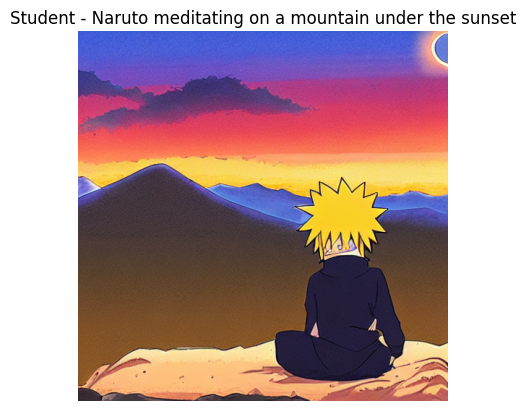

In [14]:
student.to("cuda")

# Met les sous-modules en mode évaluation
student.unet.eval()
student.vae.eval()
student.text_encoder.eval()
student.safety_checker = None  # désactive le filtre NSFW

prompt = "Naruto meditating on a mountain under the sunset"
generator = torch.manual_seed(42)

with torch.autocast("cuda"):
    result = student(prompt=prompt, num_inference_steps=50, guidance_scale=7.5, generator=generator)

image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title("Student - " + prompt)
plt.show()

## 10. Génération et affichage de l'image (Teacher)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/models/attention_processor.py:1871: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(


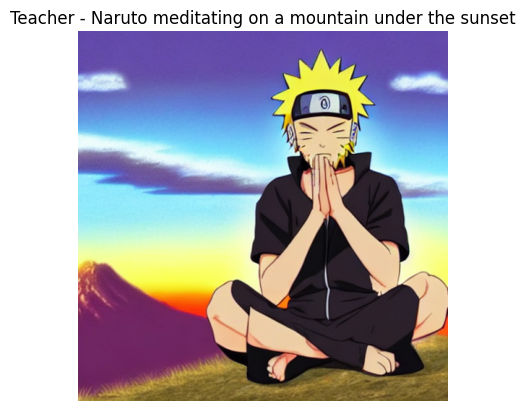

In [ ]:
teacher.to("cuda")

# Met les sous-modules en mode évaluation
teacher.unet.eval()
teacher.vae.eval()
teacher.text_encoder.eval()
teacher.safety_checker = None  # désactive le filtre NSFW

prompt = "Naruto meditating on a mountain under the sunset"

with torch.autocast("cuda"):
    result = teacher(prompt=prompt, num_inference_steps=50)

image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title("Teacher - " + prompt)
plt.show()

---------------------------------------------------------------------------